<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_with_latent_subspaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational Autoencoder Model (VAE) with latent subspaces based on:
https://arxiv.org/pdf/1812.06190.pdf

In [0]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('dark_background')

import pandas as pd

In [0]:
df1 = pd.read_csv("dge.txt",delimiter="\t")
df2 = pd.read_csv("geometry.txt",delimiter="\t")

In [0]:
X = df1.to_numpy()

In [0]:
U = df2.to_numpy()
U = U[0:X.shape[0],:]

In [0]:
U_temp = []
for i in range(X.shape[0]):
  ss = U[i][0]
  ff = np.fromstring(ss, dtype=float, sep=' ')
  U_temp.append(ff)

U = np.array(U_temp)
U = U/np.max(np.abs(U), axis=0)

In [0]:
#Reconstruction loss
def x_given_w_z(w, z, output_size):
  with tf.variable_scope('M/x_given_w_z'):
    act = tf.nn.leaky_relu
    
    h = tf.concat((w,z), axis=-1)
    h = tf.layers.dense(h, 8, act)
    h = tf.layers.dense(h, 16, act)
    h = tf.layers.dense(h, 32, act)
    h = tf.layers.dense(h, 64, act)
    loc = tf.layers.dense(h, output_size)
    #log_variance = tf.layers.dense(x, latent_size)
    #scale = tf.nn.softplus(log_variance)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


#KL term for w
def w_given_x_y(x, y, latent_size): #+
  with tf.variable_scope('M/w_given_x_y'):
    act = tf.nn.leaky_relu
    h = tf.concat((x,y), axis=-1)
    
    h = tf.layers.dense(h, 64, act)
    h = tf.layers.dense(h, 32, act)
    h = tf.layers.dense(h, 16, act)
    h = tf.layers.dense(h, 8, act)
    
    loc = tf.layers.dense(h,latent_size)
    log_variance = tf.layers.dense(h, latent_size)
    scale = tf.nn.softplus(log_variance)
    #scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

def w_given_y(y, y_size):
  with tf.variable_scope('M/w_given_y'):
    act = tf.nn.leaky_relu
    h = y
    
    h = tf.layers.dense(h, 64, act)
    h = tf.layers.dense(h, 32, act)
    h = tf.layers.dense(h, 16, act)
    h = tf.layers.dense(h, 8, act)
    
    loc = tf.layers.dense(h, y_size)
    log_variance = tf.layers.dense(h, y_size)
    scale = tf.nn.softplus(log_variance)
    return tfd.MultivariateNormalDiag(loc, scale)


#KL term for z
def z_given_x(x, latent_size): #+
  with tf.variable_scope('M/z_given_x'):
    act = tf.nn.leaky_relu
    h = x
    
    h = tf.layers.dense(h, 64, act)
    h = tf.layers.dense(h, 32, act)
    h = tf.layers.dense(h, 16, act)
    h = tf.layers.dense(h, 8, act)
    
    loc = tf.layers.dense(h,latent_size)
    log_variance = tf.layers.dense(h, latent_size)
    scale = tf.nn.softplus(log_variance)
#     scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

def z_given(latent_size):
  with tf.variable_scope('M/z_given'):
    loc = tf.zeros(latent_size)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


#For the Mutual information term
def y_given_z(z, y_size, reuse=None):
  with tf.variable_scope('N', reuse=reuse):
    act = tf.nn.leaky_relu
    h = z
    
    h = tf.layers.dense(h, 64, act)
    h = tf.layers.dense(h, 32, act)
    h = tf.layers.dense(h, 16, act)
    h = tf.layers.dense(h, 8, act)
    
    loc = tf.layers.dense(h, y_size)
    log_variance = tf.layers.dense(h, y_size)
    scale = tf.nn.softplus(log_variance)
    #scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x_in = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_in')
x_out = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_out')
u_in = tf.placeholder(tf.float32, shape=[None, 3], name='u_in')


beta = np.array([1000.0, 1.0, 1.0, 1.0, 1.0])

z_latent_size = 2
w_latent_size = 2

M_learning_rate = 1e-3
N_learning_rate = 1e-4

#KL_w
wIy = w_given_y(u_in, w_latent_size)
wIxy = w_given_x_y(x_in, u_in, w_latent_size)
wIxy_sample = wIxy.sample()
wIxy_mean = wIxy.mean()
kl_w = tf.reduce_mean(wIxy.log_prob(wIxy_sample)- wIy.log_prob(wIxy_sample))

#KL_z
zI = z_given(z_latent_size)
zIx = z_given_x(x_in, z_latent_size)
zIx_sample = zIx.sample()
zIx_mean = zIx.mean()
kl_z = tf.reduce_mean(zIx.log_prob(zIx_sample)- zI.log_prob(zIx_sample))

#Reconstruction
xIwz = x_given_w_z(wIxy_sample, zIx_sample, X.shape[1])
rec_out = xIwz.mean()
rec_loss = tf.losses.mean_squared_error(x_out, rec_out)

M1 = beta[0]*rec_loss + beta[1]*kl_w + beta[2]*kl_z

yIz = y_given_z(zIx_sample, U.shape[1], reuse=False)
ent2 = -tf.reduce_mean(-yIz.entropy())
M2 = beta[3]*ent2

M_cost = M1 + M2

M_optimizer = tf.train.AdamOptimizer(M_learning_rate)

M_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='M/')
M_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='M/')

with tf.control_dependencies(M_update_ops):
  M_train = M_optimizer.minimize(M_cost, var_list=M_train_vars,
                                       name='train_M')

  
yIz_N = y_given_z(zIx_sample, U.shape[1], reuse=True)
logN = tf.reduce_mean(-yIz_N.log_prob(u_in))
N = beta[4]*logN

N_cost = N

N_optimizer = tf.train.AdamOptimizer(N_learning_rate)

N_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='N')
N_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='N')

with tf.control_dependencies(N_update_ops):
  N_train = N_optimizer.minimize(N_cost, var_list=N_train_vars,
                                       name='train_N')

# Saver to save session for reuse
saver = tf.train.Saver()

In [0]:
#Helper function
def batch_generator(features, x, u, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:], x[part,:] , u[part, :]

In [294]:
n_epochs = 5000
batch_size = X.shape[0]
start = time.time()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  
  for i in range(n_epochs):
    gen = batch_generator(X, X, U, batch_size) #create batch generator
    M_loss = 0
    N_loss = 0
    rec_loss_ = 0
    kl_w_ = 0
    kl_z_ = 0
    M1_ = 0
    M2_ = 0
    ent2_ = 0
    logN_ = 0
    
    for j in range(np.int(X.shape[0]/batch_size)):
      x_in_batch, x_out_batch, u_batch = gen.__next__()
      
      
      _, M_loss_, rec_loss__, kl_w__, kl_z__, M1__, ent2__, M2__= sess.run([M_train, M_cost, rec_loss, kl_w, kl_z, M1, ent2, M2], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch})
      M_loss += M_loss_
      rec_loss_ += rec_loss__
      kl_w_ += kl_w__
      kl_z_ += kl_z__
      M1_ += M1__
      M2_ += M2__
      
      _, N_loss_, logN__= sess.run([N_train, N_cost, logN], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch})
      N_loss += N_loss_
      logN_ += logN__
      
      
    if (i+1)% 50 == 0 or i == 0:
      wIxy_mean_, zIx_mean_, rec_out_= sess.run([wIxy_mean, zIx_mean, rec_out], feed_dict ={x_in:X, x_out:X, u_in:U})
      end = time.time()
      print('epoch: {0}, M_loss: {1:.1f}, M1_loss: {2:.1f}, M2_loss: {3:.1f}, N_loss: {4:.2f}'.format((i+1), M_loss/(1+np.int(X.shape[0]/batch_size)), M1_/(1+np.int(X.shape[0]/batch_size)), M2_/(1+np.int(X.shape[0]/batch_size)), N_loss_/(1+np.int(X.shape[0]/batch_size))))
      print('epoch: {0}, rec_loss: {1:.3f}, kl_w: {2:.2f}, kl_z: {3:.2f}'.format((i+1), rec_loss_/(1+np.int(X.shape[0]/batch_size)), kl_w_/(1+np.int(X.shape[0]/batch_size)), kl_z_/(1+np.int(X.shape[0]/batch_size))))
      start = time.time()

epoch: 1, M_loss: 2648.1, M1_loss: 2646.6, M2_loss: 1.5, N_loss: 1.29
epoch: 1, rec_loss: 0.058, kl_w: 0.13, kl_z: 2588.72
epoch: 50, M_loss: 427.6, M1_loss: 426.1, M2_loss: 1.5, N_loss: 1.26
epoch: 50, rec_loss: 0.019, kl_w: 0.25, kl_z: 407.25
epoch: 100, M_loss: 25.7, M1_loss: 24.2, M2_loss: 1.5, N_loss: 1.23
epoch: 100, rec_loss: 0.018, kl_w: 0.20, kl_z: 6.41
epoch: 150, M_loss: 20.3, M1_loss: 18.8, M2_loss: 1.5, N_loss: 1.19
epoch: 150, rec_loss: 0.016, kl_w: 0.43, kl_z: 2.69
epoch: 200, M_loss: 17.1, M1_loss: 15.6, M2_loss: 1.4, N_loss: 1.16
epoch: 200, rec_loss: 0.013, kl_w: 0.46, kl_z: 1.80
epoch: 250, M_loss: 15.6, M1_loss: 14.2, M2_loss: 1.4, N_loss: 1.14
epoch: 250, rec_loss: 0.012, kl_w: 0.37, kl_z: 1.43
epoch: 300, M_loss: 14.5, M1_loss: 13.1, M2_loss: 1.4, N_loss: 1.12
epoch: 300, rec_loss: 0.012, kl_w: 0.29, kl_z: 1.06
epoch: 350, M_loss: 13.9, M1_loss: 12.6, M2_loss: 1.4, N_loss: 1.11
epoch: 350, rec_loss: 0.011, kl_w: 0.24, kl_z: 0.95
epoch: 400, M_loss: 13.2, M1_loss: 

Text(0, 0.5, 'z2')

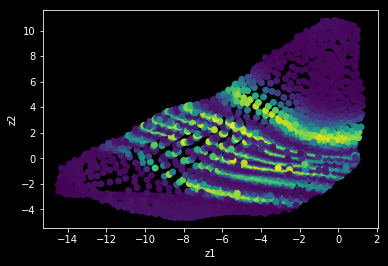

In [295]:
plt.scatter(wIxy_mean_[:,0],wIxy_mean_[:,1], c=df1['eve'].to_numpy(), cmap='viridis');
plt.xlabel('z1')
plt.ylabel('z2')

Text(0, 0.5, 'z2')

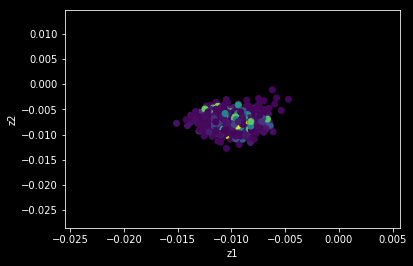

In [296]:
plt.scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=df1['eve'].to_numpy(), cmap='viridis');
plt.xlabel('z1')
plt.ylabel('z2')

In [0]:
error = np.abs(rec_out_-X)

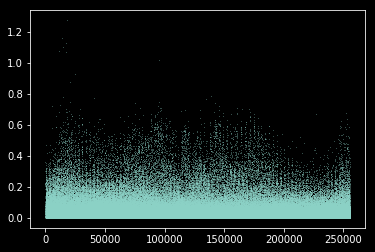

In [298]:
plt.plot(np.reshape(error, -1), '*', markersize=0.1);

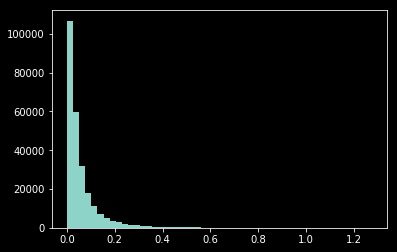

In [299]:
plt.hist(np.reshape(error, -1), bins=50);

In [300]:
np.mean(np.reshape(error, -1))

0.05687963157809768

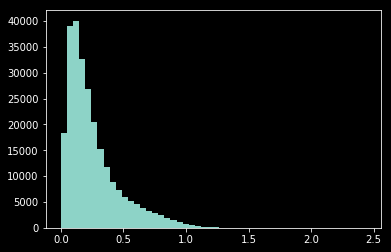

In [301]:
plt.hist(np.reshape(X, -1), bins=50);

In [0]:
# def configure_plotly_browser_state():
#   import IPython
#   display(IPython.core.display.HTML('''
#         <script src="/static/components/requirejs/require.js"></script>
#         <script>
#           requirejs.config({
#             paths: {
#               base: '/static/base',
#               plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
#             },
#           });
#         </script>
#         '''))

# import plotly.plotly as py
# from plotly.offline import init_notebook_mode, iplot
# from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

# configure_plotly_browser_state()

# init_notebook_mode(connected=False)


# import plotly.graph_objs as go


# trace1 = go.Scatter3d(
#     x=wIxy_sample_[:,0],
#     y=wIxy_sample_[:,1],
#     z=wIxy_sample_[:,2],
#     name = 'train data: line',
#     mode='markers',
#     marker=dict(
#         size=3.0,
#         color=df1['eve'].to_numpy(),                # set color to an array/list of desired values
#         colorscale='Viridis',   # choose a colorscale
#         opacity=0.8
#     )
# )


# data = [trace1]
# layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
# )



# fig = go.Figure(data=data, layout=layout)
# iplot(fig, filename='3d-scatter-colorscale')